#Setup

In [ ]:
import sys
import numba
import scipy
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve
from scipy.sparse.linalg import LinearOperator
from scipy.sparse import random
from scipy import sparse
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from numba import cuda
from numba import njit, prange, jit
from scipy.sparse import coo_matrix
import pandas as pd
import seaborn as sb
%matplotlib inline

#Functions

In [ ]:
def Naive_CSR_Ellpack(csr):
  """A function taking a csr matrix and returning an ellpack matrix."""
  #Separating data, indices and indptr into their own arrays.
  data = csr.data 
  indices = csr.indices
  indptr = csr.indptr
  #Number of rows is the length of the pointer array -1.
  N_rows = int(len(indptr[:-1])) 
  row_length = np.zeros(N_rows)
  #To find the maximum number of non-zero elements, we loop through the array and count.
  for n in range(N_rows):
    row_length[n] = int(indptr[n+1] - indptr[n])
  max_row_length = int(row_length.max())
  #The ellpack matrix is made from entries and column, size (N,M).
  entries, column = np.zeros(shape=(N_rows,max_row_length)), np.zeros(shape=(N_rows,max_row_length))
  #loop through row and col, assigning data->entries and indices->colum using the pointer.
  for i in range(N_rows):
    for j in range(int(row_length[i])):
      entries[i,j] = data[indptr[i]+j]
      column[i,j] = int(indices[indptr[i]+j])
      row_length[i] = int(1+j)  
  return entries, column, row_length

def naive_ell_vec_prod(ell_mat, vec):
    """Takes an ellpack format matrix and returns a multiplication with a 1D vector."""
    values = ell_mat[0]
    column = ell_mat[1]
    rlength = ell_mat[2]
    res = np.zeros_like(vec)
    for i in range(len(values)):
      for j in range(int(rlength[i])):
        res[i] = res[i] + values[i,j] * vec[int(column[i,j])]
    return res
################################################################################
@njit #Allows for parallelization. 
def Parallel_iteration(data, indices, indptr):
  """Parallelized csr to ellpack."""
  N_rows = int(len(indptr[:-1]))
  row_length = np.zeros(N_rows)
  for n in prange(N_rows): #prange allows parallelizeation.
    row_length[n] = int(indptr[n+1] - indptr[n])
  max_row_length = int(row_length.max())
  entries, column = np.zeros(shape=(N_rows,max_row_length)), np.zeros(shape=(N_rows,max_row_length))
  for i in prange(N_rows):
    for j in range(int(row_length[i])):
      entries[i,j] = data[indptr[i]+j]
      column[i,j] = int(indices[indptr[i]+j])
      row_length[i] = int(1+j)
  return entries, column, row_length

def Parallel_CSR_Ellpack(csr): 
  #If this was all C-compiled, csr would have to be csr.data, csr.indices and csr.indptr.
  """Parallelized ellpack matrix-vector multiplication."""
  data = csr.data
  indices = csr.indices
  indptr = csr.indptr
  #Call the iteration. This means we may pass the csr format as one, not three arrays.
  entries, column, row_length = Parallel_iteration(data, indices, indptr)
  return entries, column, row_length

@njit
def parallel_ell_vec_prod(ell_mat, vec):
    """Matrix-vector product parallelized."""
    values = ell_mat[0]
    column = ell_mat[1]
    rlength = ell_mat[2]
    res = np.zeros_like(vec)
    for i in prange(len(values)): #parallelized.
      for j in range(int(rlength[i])):
        res[i] = res[i] + values[i,j] * vec[int(column[i,j])]
    return res
################################################################################
@cuda.jit()
def single_GPU_iteration(GPU_data, GPU_indices, GPU_indptr, GPU_entries, GPU_column, N_rows, GPU_row_length):
  """Function takes the machine compiled arrays and outputs a results(res) array of the 
  entries and columns in ellpack format.
  NO LONGER USED"""
  for i in range(N_rows): #i is the therads, each thread loopos over a row..
    for j in range(int(GPU_row_length[i])): #looping through columns(j).
      GPU_entries[i,j] = GPU_data[GPU_indptr[i]+j]
      GPU_column[i,j] = int(GPU_indices[GPU_indptr[i]+j])
      cuda.syncthreads() #Ensures the threads are in sync.     

def GPU_CSR_Ellpack(csr):
  """Use the GPU compiled function to convert csr->ellpack format.
  NO LONGER USED"""
  data = csr.data
  indices = csr.indices
  indptr = csr.indptr
  N_rows = int(len(indptr[:-1]))
  row_length = np.zeros(N_rows)
  for n in range(N_rows):
    row_length[n] = int(indptr[n+1] - indptr[n])
  max_row_length = int(row_length.max())
  entries, column = np.zeros(shape=(N_rows,max_row_length)), np.zeros(shape=(N_rows,max_row_length))
  TPB = 16 #Therads per Blcok
  BPG = (N_rows+TPB)//TPB #Blocks per Grid
  GPU_data = cuda.to_device(data)
  GPU_indices = cuda.to_device(indices)
  GPU_indptr = cuda.to_device(indptr)
  GPU_entries = cuda.to_device(entries)
  GPU_column = cuda.to_device(column)
  GPU_row_length = cuda.to_device(row_length)
  single_GPU_iteration[BPG, TPB](GPU_data, GPU_indices, GPU_indptr, GPU_entries, GPU_column, N_rows, GPU_row_length)
  entries = GPU_entries.copy_to_host()
  column = GPU_column.copy_to_host()
  return entries, column, row_length

@cuda.jit()
def GPU_single_iteration_multiply(GPU_values, GPU_rlength, GPU_res, GPU_vec, GPU_column):
  i = cuda.grid(1)
  if i > len(GPU_values):
    temp_element = 0
    for j in range(int(GPU_rlength[i])):
      temp_element += GPU_res[i] + GPU_values[i,j] * GPU_vec[int(GPU_column[j,i])]
      cuda.syncthreads()
    GPU_res[i] = temp_element

def GPU_ell_vec_prod(ell_mat, vec):
    """NO LONGER USED"""
    values = ell_mat[0]
    column = ell_mat[1]
    rlength = ell_mat[2]
    res = np.zeros_like(vec)
    TPB = 16 #Therads per Blcok
    BPG = (len(rlength)+TPB)//TPB #Blocks per Grid
    GPU_values = cuda.to_device(values)
    GPU_rlength = cuda.to_device(rlength)
    GPU_res = cuda.to_device(res)
    GPU_vec = cuda.to_device(vec)
    GPU_column = cuda.to_device(column)
    GPU_single_iteration_multiply[BPG, TPB](GPU_values, GPU_rlength, GPU_res, GPU_vec, GPU_column)
    res = GPU_res.copy_to_host()
    return res
################################################################################
def discretise_poisson(N):
    """Generate the matrix and rhs associated with the discrete Poisson operator."""
    nelements = 5 * N**2 - 16 * N + 16
    row_ind = np.empty(nelements, dtype=np.float64)
    col_ind = np.empty(nelements, dtype=np.float64)
    data = np.empty(nelements, dtype=np.float64)
    f = np.empty(N * N, dtype=np.float64)
    count = 0
    for j in range(N):
        for i in range(N):
            if i == 0 or i == N - 1 or j == 0 or j == N - 1:
                row_ind[count] = col_ind[count] = j * N + i
                data[count] =  1
                f[j * N + i] = 0
                count += 1
            else:
                row_ind[count : count + 5] = j * N + i
                col_ind[count] = j * N + i
                col_ind[count + 1] = j * N + i + 1
                col_ind[count + 2] = j * N + i - 1
                col_ind[count + 3] = (j + 1) * N + i
                col_ind[count + 4] = (j - 1) * N + i            
                data[count] = 4 * (N - 1)**2
                data[count + 1 : count + 5] = - (N - 1)**2
                f[j * N + i] = 1
                count += 5                         
    return coo_matrix((data, (row_ind, col_ind)), shape=(N**2, N**2)).tocsr(), f

#Class Implimentation

In [ ]:
class NaiveEllpackMatrix(LinearOperator):

  def __init__(self, csr):
    self.data = csr.data
    self.indices = csr.indices
    self.indptr = csr.indptr
    N_rows = int(len(self.indptr[:-1]))
    self.row_length = np.zeros(N_rows, dtype=np.int64)
    
    for n in range(N_rows):
      self.row_length[n] = int(self.indptr[n+1] - self.indptr[n])
    M_max = int(self.row_length.max())
    self.shape = (M_max, N_rows)
    self.dtype = None
    self.entries, self.column = np.zeros(shape=(N_rows,M_max), dtype=np.float64), np.zeros(shape=(N_rows,M_max), dtype=np.int64)
    for i in range(N_rows):
      for j in range(int(self.row_length[i])):
        self.entries[i,j] = self.data[self.indptr[i]+j]
        self.column[i,j] = int(self.indices[self.indptr[i]+j])
        self.row_length[i] = int(1+j) 
    self.entries = self.entries.astype('float64')
    self.column = self.column.astype('float32')

  def _matvec(self,vec):
    self.res = np.zeros(shape=self.shape[1], dtype=np.float64)
    for r in range(self.shape[1]):
      for c in range(int(self.row_length[r])):
        self.res[r] = self.res[r] + self.entries[r,c] * vec[int(self.column[r,c])]
    return self.res

csr_mat = random(2000, 2000, density=0.1, format='csr')
dense = csr_mat.todense()
my_sparse_mat = NaiveEllpackMatrix(csr_mat)
x = np.random.randn(my_sparse_mat.shape[1])
y = my_sparse_mat._matvec(vec=x)

print("Class implimented Naive Relative Error:", np.linalg.norm(y - np.dot(dense, x))/np.linalg.norm(np.dot(dense, x)))
################################################################################
class EllpackMatrix(LinearOperator):

  def __init__(self, csr):
    """
    Inputs: csr matrix
    
    Outputs: ellpack = entries, indices, indptr

    - Uses self.shape and self.dtype as required by sparse.LinearOperator.
    - shape = (max number of non-zero elements in any row, row number)
    - 
    """
    self.data = csr.data
    self.indices = csr.indices
    self.indptr = csr.indptr
    N_rows = int(len(self.indptr[:-1]))
    self.row_length = np.zeros(N_rows, dtype=np.int64)
    
    for n in range(N_rows):
      self.row_length[n] = int(self.indptr[n+1] - self.indptr[n])
    M_max = int(self.row_length.max())
    self.shape = (M_max, N_rows)
    self.dtype = None
    self.entries, self.column = np.zeros(shape=(N_rows,M_max), dtype=np.float64), np.zeros(shape=(N_rows,M_max), dtype=np.int64)
    for i in range(N_rows):
      for j in range(int(self.row_length[i])):
        self.entries[i,j] = self.data[self.indptr[i]+j]
        self.column[i,j] = int(self.indices[self.indptr[i]+j])
        self.row_length[i] = int(1+j) 
    self.entries = self.entries.astype('float64')
    self.column = self.column.astype('float32')

  @staticmethod
  @cuda.jit()    
  def GPU_matvec_iteration(GPU_vec, GPU_res, GPU_shape, GPU_entries, GPU_column, GPU_row_length):
    r = cuda.grid(1)
    if r < GPU_vec.shape[0]:
      temp_element = 0
      for c in range(int(GPU_row_length[r])):
        temp_element += GPU_res[r] + GPU_entries[r,c] * GPU_vec[int(GPU_column[r,c])]
        cuda.syncthreads()
      GPU_res[r] = temp_element
      

  def _matvec(self,vec):
    """
    Inputs: vector

    Outputs: matrix-vector product

    - Uses the GPU to conduct a matvec.
    - Memory optimized as the 2D array is in column major format.
    - Due to version issues with scipy, _matvec does not overide the @ symbol.
    """
    self.res = np.zeros(shape=self.shape[1])

    TPB = 16 #ThreadsPerBlock
    BPG = (self.shape[1]+TPB)//TPB #BlocksPerGrid
    GPU_vec = cuda.to_device(vec) #Assigning local variables
    GPU_res = cuda.to_device(self.res)
    GPU_shape = cuda.to_device(self.shape)
    GPU_entries = cuda.to_device(self.entries)
    GPU_column = cuda.to_device(self.column)
    GPU_row_length = cuda.to_device(self.row_length)
    self.GPU_matvec_iteration[(BPG,1), (TPB, 1)](GPU_vec, GPU_res, GPU_shape, GPU_entries, GPU_column, GPU_row_length)
    self.res = GPU_res.copy_to_host() #Pulling local variables
    return self.res

csr_mat = random(3000, 3000, density=0.01, format='csr')
dense = csr_mat.todense()
my_sparse_mat = EllpackMatrix(csr_mat)
x = np.random.randn(my_sparse_mat.shape[1])
y = my_sparse_mat._matvec(vec=x)

print("Class implimented GPU Relative Error:", np.linalg.norm(y - np.dot(dense, x))/np.linalg.norm(np.dot(dense, x)))

Class implimented Naive Relative Error: 5.212784232455942e-16
Class implimented GPU Relative Error: 2.391172364818289e-16


#Task 1:

##Storage Formats

The ways of storing sparse matrices are in two groups. The first group include things like Dictionary of Keys (DOK), Lists of Lists (LIL) and Coordinate Lists (COO), which use coordinates to guide non-zero element indexing. The COO format for example uses the coordinates of each non-zero element to index the elements, leaving three arrays of values, rows, and columns. These are easy to construct and modify, but arithmetic is difficult on them . For example, DOKs may be accessed, read, and replaced, but as mapping between values and row-column keys is a slow process, matrix multiplication is slow. To fix this, the second group (including CSR and CSC formats) were introduced. These are more complex to create but allows for matrix operations, the difference is that the second group use pointers, rather than coordinates. CSR is like the COO format, except that the row indices are compressed to remove repeats. This vector becomes the intpdr which points to changes in rows, instead of the actual row. This has some major upsides but still has issues which are outlined in this discussion.


In [ ]:
dense = np.array([[1,0,0,2,0],[0,0,0,3,0],[0,0,0,4,0],[0,0,0,0,0],[5,6,0,0,0]])
sparse = csr_matrix(dense)
print("Dense matrix uses",sys.getsizeof(dense),"bytes of Memory","\n",dense)
print("Sparse CSR matrix uses",sys.getsizeof(sparse),"bytes of Memory","\n",sparse)

Dense matrix uses 312 bytes of Memory 
 [[1 0 0 2 0]
 [0 0 0 3 0]
 [0 0 0 4 0]
 [0 0 0 0 0]
 [5 6 0 0 0]]
Sparse CSR matrix uses 64 bytes of Memory 
   (0, 0)	1
  (0, 3)	2
  (1, 3)	3
  (2, 3)	4
  (4, 0)	5
  (4, 1)	6


##Compressed Row Storage (CSR)

One of the key formats widely used in CPU programming is the CSR (Compressed Sparse Row) format. This format creates three 1 dimensional arrays, which together describe a sparse matrix. The first is an array of data, the float values of non-zero elements. The following array is the indices, an array of integers representing the column indices for each non-zero element. Lastly, the indptr array of integers shows where in the indices (and data) array a new row begins. This intptr array is of size N+1 where N is the number of rows, this last value is the total number of non-zero elements. This means an element can be placed by using dense dense[column[intptr[i]],j] = data[indptr[i],j]. 
There are many benefits to using the CSR format over a dense matrix. The largest relates to memory requirements, as a dense matrix stores every element (including the useless zeros) while a sparse matrix stores only non-zero elements. This saves huge amounts of memory, for a dense 40,000 x 40,000 matrix 12 GB of RAM is needed, while a sparse matrix may realistically need single digits of RAM (see lectures). In the above code cell, it can be seen that CSR takes 20% of the memory of just a 5x5 dense matrix. The data, columns and indptr arrays can also be seen. 


## Issues with CSR

In the context of Sparse-Matrix Vector Products (SpMV) Vazquez et al. [1] discuss some issues. Firstly, the iterative approach of SpMV means that while the sparse matrix may be memory optimised (through locality) the multiplying vector is not stored and accessed efficiently. As the sparse matrix is looped through (skipping zero values) the corresponding values in the vector must be accessed. Therefore, as consecutive non-zero corresponding vector values are rarely in consecutive memory space, the multiplication is slowed. The large jumps between data points in the vector mean that consecutive points may not fit in the cache, so must be pulled from the global memory. This is exacerbated when using GPUs as memory must be pre-allocated. 
However, a larger problem lies in the shape of each matrix row. The data and column indices arrays do not have constant width. This means that loops over each row are generally small, but variable. In the above example they would be 2, 1, 1, 0, 2. This means that parallelism (the most powerful method of speed up) is impossible because threads become out of sync on different length rows. In the SpMV calculation each row must be iterated over, and this means that naive implementation performance is hard to improve on.


##Ellpack and Vazquez et al.

The paper by Vazquez et.al. summarizes the matrix vector products for types of sparse formats and discusses improvements to the method. The writers suggest the use of Ellpack-R format in sparse matrices; a format which they conclude is better than many other widely used formats which they tested against in multiplication. 

In this paper, Vazquez et.al. suggest the use of Ellpack (alternatively Itpack) formatting. In this format, the datapoint floats are placed into an array, and the integer column indices are placed into an array. Each is of size (N x M) where M is the maximum number of non-zeros in any row. Note here that the empty elements are padded with zeros. This format has many benefits, such as its dense-like formatting. This allows the Ellpack matrices to be vectorized and used in GPU threads. The other two performance enhancements are due to memory optimization and thread synchrony. Memory usage is optimized because consecutive threads access consecutive memory addresses. This is due to the column-major formatting used in Ellpack. Each thread accesses memory that is ‘M’ apart in the memory. The threads are also guaranteed to maintain synchrony as each row is of identical length due to the padded zeros. This means each thread block may execute its computations without waiting. The Ellpack offers a major upgrade from the CSR format because of these. The CSR could not maintain synchronization or optimal memory access; both due to its variable row lengths. Having fixed this, SpMV using Ellpack may be calculated on GPUs and optimized in many more ways.


In [ ]:
ellpack = Naive_CSR_Ellpack(sparse)
print("Ellpack matrix uses",sys.getsizeof(ellpack),"bytes of Memory","\n", ellpack[0],"\n", ellpack[1],"\n", ellpack[2])

Ellpack matrix uses 80 bytes of Memory 
 [[1. 2.]
 [3. 0.]
 [4. 0.]
 [0. 0.]
 [5. 6.]] 
 [[0. 3.]
 [3. 0.]
 [3. 0.]
 [0. 0.]
 [0. 1.]] 
 [2. 1. 1. 0. 2.]


##Issues with Ellpack

While the performance is improved, there is one issue with Ellpack. For a given matrix, the chance that one row will be orders-of-magnitude larger than the others is not negligible. This means that most rows will be made of mostly zeros. This is cumbersome and creates a dense matrix which programmers would otherwise convert to a sparse matrix. This issue with Ellpack was worked on by Bell and Garland in their 2009 paper [2]. In their paper they implement a HPB format by separating the rows of the sparse matrix by the number of non-zero elements. With a specific, predefined number of large rows (for example the largest 1% of non-zero rows) the Ellpack format may be used on the smaller (99%) and a COO format used on the (1%). This removes the issue of the ‘many-zeros’ problem Ellpack experienced before but introduces another. The kernels ran on the COO formatted rows cannot be memory optimized or synched so cannot (unlike the now smaller Ellpack format) be ran on a GPU. Similarly, the sliced-Ellpack developed by Monakov et.al. [3] in 2010 develops the Ellpack method, however it has large pre-processing requirements and is therefore less useful. Ellpack-R is a development described by Vazquez et.al.with a method almost identical to the Ellpack method of creating dense matrices from the sparse matrix. The difference is that the Ellpack-R format adds an integer vector of length N where each row is the same number. This number is the number of columns in each row, this is independent of any padding zeros. This can be elaborated into Ellpack-T when Ellpack-R is running on a GPU with T threads. This means that when calculating the ith row, the row is split between the T threads, and each thread runs the calculation on its element. The T results are collated from the shared memory to get the result. Better performance can be achieved with T’s tuning. This new Ellpack-T has many advantages, including optimized memory usage, intra-warp homogenous computing, minimized thread wastage and high occupancy. 


##Subsequent Research and Novel Formatting

Since the Vazquez paper in 2010 many more formats have been utilised three will be discussed here. Immediately after Vazquez published in 2010, Mrozowski [4] released a new format, the Sliced-EllR-T. In 2011 their team proposed a format relying on existing ideas, the slicing of the Sliced Ellpack, and the thread use of Ell-T. Together, these features resulted in a memory reduction of 559MB between the ELLR-T and Sliced ELLR-T. In the SpMV calculation, a speed of 69 69GFLOPS was achieved, improving on the ELLR (see Figure 2 of their paper) value of 50GFLOPS. 

In 2012, Kreutzer et.al. [5] suggested the pJDS or padded Jagged Diagonals Storage format. Here, rows are sorted by number of non-zero elements and separated into groups. The size of these groups depends on block size, with each block being filled with as many rows (of descending, similar lengths) as it can. Each block has padding corresponding to the largest non-zero row length. Unlike other sparse matrix formats which have developed since 2012, this requires no knowledge of the matrix structure. This offers memory savings over the ELLPACK and ELLPACK-R formats, as there is minimal padding. Executing Sparse-Matrix-Vector-Matrix calculations  with the pJDS format gives a performance of ~95GFLOPS, about 15GFLOPS higher than the naïve implementation of ELLPACK (Figure 5 in their paper). Due to the smallness of the (non-zero) matrices they used; this performance improvement is not as high as expected. Therefore, the performance graph slopes like a log-chart in Figure 5a of their paper. This is due to the large node (thread block size) ratio to row number. Each block has few rows to iterate through, so the benefits become less impactful with larger thread block sizes.

More recently in 2021, Kozicky and Simecek propose the HSF-2 format. Hierarchical Storage Format save memory space by separating the matrix into sparse blocks. Each block includes a sub-matrix of non-zero elements. See Figure 1 of their paper [6] for illustration. In this paper however they suggest a further step, separating these blocks into even smaller matrices and storing them with an index of the first element in each sub-matrix. For a further description please see the paper’s introduction. This development slowed a median performance in SpMTV (Sparse-Matrix-MatrixTransposed-vector) Multiplication of 8GFLOPS, double the CSR implementations 5GFLOPS.


#Task 2

The first section of the executions will be executed with the functions because this gives more flexibility over which parts to time and the writer can specifically target sections of the algorithm to analyse. The second half (Solving the Poisson Problem and using the matrix market will impliment the EllpackMatrix class. This is because these are more holistic problems which will benifit 

## N=1000 Sparse CSR matrix

First of all, can a matrix be operated on such that a CSR formatted matrix can pass to a Ellpack format, and then be multiplied by a vector. The functions defined above allow these algorithms to be executed below. The relative error is displayed for naive, parallel and GPU implimentations. The 'perfect' result is calculated with np.dot() on the dense version of the CSR matrix.  

In [ ]:
A = random(10000, 10000, density=0.01, format='csr')
x = np.random.randn(A.shape[1])
Ellpack = Naive_CSR_Ellpack(A)
Parallel_Ellpack = Parallel_CSR_Ellpack(A)
GPU_Ellpack = EllpackMatrix(A)
print("Errors in implemented method vs numpy.dot():")

print("Linear Relative Error:",np.linalg.norm(naive_ell_vec_prod(Ellpack, x) - A.dot(x))/np.linalg.norm(A.dot(x)))
print("Parallel Relative Error:",np.linalg.norm(parallel_ell_vec_prod(Parallel_Ellpack, x) - A.dot(x))/np.linalg.norm(A.dot(x)))
print("GPU Relative Error:",np.linalg.norm(GPU_Ellpack._matvec(vec=x) - A.dot(x))/np.linalg.norm(A.dot(x)))

Errors in implemented method vs numpy.dot():
Linear Relative Error: 0.0
Parallel Relative Error: 0.0
GPU Relative Error: 0.0


##Random Vectors

Below is code creating 3 random vectors of size 10000. These are multiplied by the sparse array created by initialising EllpackMatrix on a CSR matrix. From here the error is calculated with the 'true' value of scipy's matvec function through array @ vector. 

As the reader can see, the agorithms work to machine precision.

In [ ]:
my_sparse_mat = random(10000, 10000, density=0.001, format='csr')

x1 = np.random.randn(my_sparse_mat.shape[1])
x2 = np.random.randn(my_sparse_mat.shape[1])
x3 = np.random.randn(my_sparse_mat.shape[1])
sparse = sparse.csr_matrix(my_sparse_mat)
Ellpack = EllpackMatrix(my_sparse_mat)

print("Differences in X1:","\n",np.linalg.norm(Ellpack._matvec(x1) - my_sparse_mat @ x1))
print("Differences in X2:","\n",np.linalg.norm(Ellpack._matvec(x2) - my_sparse_mat @ x2))
print("Differences in X3:","\n",np.linalg.norm(Ellpack._matvec(x3) - my_sparse_mat @ x3))

Differences in X1: 
 0.0
Differences in X2: 
 0.0
Differences in X3: 
 0.0


## Calculation Times

However, the difference in these methods should lie in their speed, not their accuracy. This is due to the parallelization of the numba and GPU implementations. 

Below each was executed again, while the time required to run the function was recorded, to plot Figure 1. The expected results are that the times to calculate will increase quadratically, and GPU will be faster than the parallelized code.

In [ ]:
exact_times, GPU_method_times, Parallel_times = [], [], []

for i in range(2,30):
  A,f = discretise_poisson(i) 
  exact_time = %timeit -oq A @ f #A.dot(f)
  GPU_mat = sparse.csr_matrix(A)
  GPU_calc = EllpackMatrix(GPU_mat)
  GPU_method_time = %timeit -oq GPU_calc._matvec(f)
  Parallel_time = %timeit -oq parallel_ell_vec_prod(Parallel_CSR_Ellpack(A), f)
  exact_times.append(exact_time.best)
  GPU_method_times.append(GPU_method_time.best)
  Parallel_times.append(Parallel_time.best)

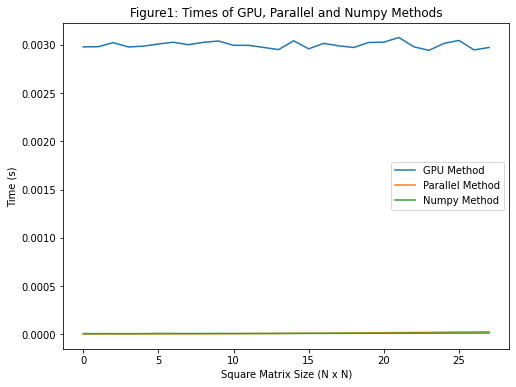

In [ ]:
plt.figure(figsize=(8, 6))
plt.title("Figure1: Times of GPU, Parallel and Numpy Methods")
plt.xlabel("Square Matrix Size (N x N)")
plt.ylabel("Time (s)")
plt.plot(GPU_method_times, label='GPU Method')
plt.plot(Parallel_times, label='Parallel Method')
plt.plot(exact_times, label='Numpy Method')
plt.legend()

Unexpectedly, the GPU implimentation was the slowest, by far. This is likely due to the large amounts of data being passed to them for each iteration. The cuda.to_device and ().copy_to_host functions are expensive. With this implimentation however there is no way to evaluate these times. Even so they are part of the algorithm, just as pre-compiling C-code is part of the numba-parallelised algorithm. 

The fact that the GPU is almost constant at 0.003s implies that there is some matrix size above which it it worth using the GPU. What is that size? It is discussed in Figure 1c.

Below in Figure 1b are the two other methods, Parallel and numpy, as the scale removed some of their features. 

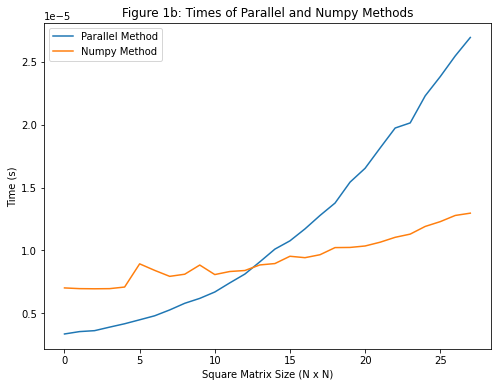

In [ ]:
plt.figure(figsize=(8, 6))
plt.title("Figure 1b: Times of Parallel and Numpy Methods")
plt.xlabel("Square Matrix Size (N x N)")
plt.ylabel("Time (s)")
plt.plot(Parallel_times, label='Parallel Method')
plt.plot(exact_times, label='Numpy Method')
plt.legend()

The relationshhip between matrix size and Parallel time is quadratic, as expected from $N\times N = N^2$. The numpy method is linear; implying, as expected that is heavily optimized. The GPU takes at least $1\times 10^3$ as much time and is obviously least efficient. 

In [ ]:
exact_times, GPU_method_times = [], [] 
Ns = [10, 50, 100, 500, 1000, 5000]
for i in Ns:
  A,f = discretise_poisson(i) 

  exact_time = %timeit -oq A @ f
  GPU_calc = EllpackMatrix(sparse.csr_matrix(A))
  GPU_method_time = %timeit -oq GPU_calc._matvec(f)
  
  exact_times.append(exact_time.best)
  GPU_method_times.append(GPU_method_time.best)

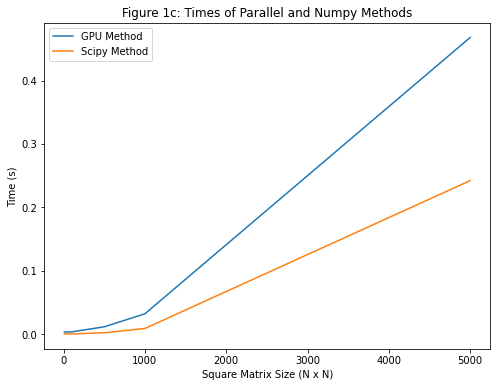

In [ ]:
plt.figure(figsize=(8, 6))
plt.title("Figure 1c: Times of Parallel and Numpy Methods")
plt.xlabel("Square Matrix Size (N x N)")
plt.ylabel("Time (s)")
plt.plot(Ns, GPU_method_times, label='GPU Method')
plt.plot(Ns, exact_times, label='Scipy Method')
plt.legend()

So, there is no crossover as hypothesised earlier. It appears to never be efficient to use a GPU over a scipy method. This is due to the same reasons discussed earlier. As the size incrases the size of array sent to the GPU increases. This slows down the GPU process exponentially.

A deeper look at the GPU performance is conducted below.

##GPU Analysis

To analyse the GPU kernal, some tests are ran. Here the calculation time and error are recorded for different densities and matrix sizes. Density in sparse matrices is the ratio of non-zero elements to all elements.

In [ ]:
Ns = [500,1000,1500,2000,2500,3000,3500,4000,4500,5000,5500,6000,6500]
density = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]
result_t = np.empty((len(Ns),len(density)))
result_e = np.empty((len(Ns),len(density)))
for n in range(len(Ns)):
  for d in range(len(density)):
    csr_mat = random(Ns[n],Ns[n], density[d], format='csr')
    dense = csr_mat.todense()
    my_sparse_mat = EllpackMatrix(csr_mat)
    x = np.random.randn(my_sparse_mat.shape[1])
    matvec_time = %timeit -oq my_sparse_mat._matvec(x)
    y = my_sparse_mat._matvec(x)
    result_t[n,d] = matvec_time.best
    result_e[n,d] = np.linalg.norm(y - dense.dot(x))/np.linalg.norm(dense.dot(x))

### Calculation Times

The calculation time should increase linearly with density and exponentially with matrix size (as NxN).

Text(114.0, 0.5, 'Density of Sparse Matrix')

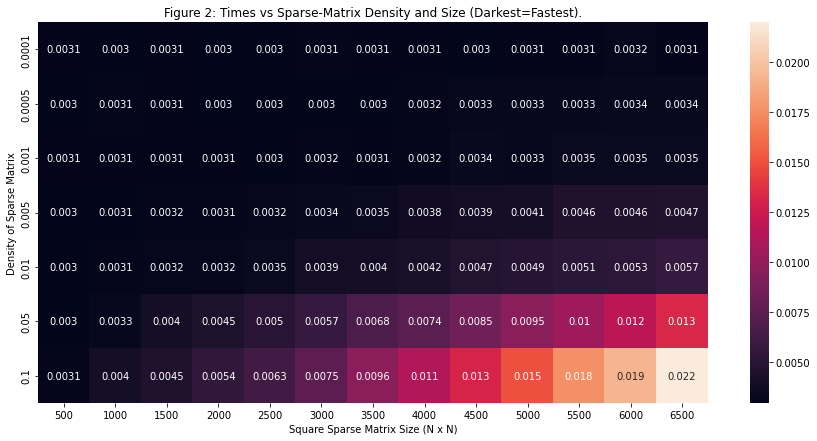

In [ ]:
data = pd.DataFrame(result_t.T, density, Ns)
plt.figure(figsize=(15, 7))
sb.heatmap(data, annot=True)
plt.title("Figure 2: Times vs Sparse-Matrix Density and Size (Darkest=Fastest).")
plt.xlabel("Square Sparse Matrix Size (N x N)")
plt.ylabel("Density of Sparse Matrix")

The Figure 2 graph shows that our hypothesis was not correct. Large matrices do not slow the GPU down, in fact the fastest time of 0.011s was on the most dense, medium size matrix. There are a few possibilities here. First that there is an error in the GPU code; unlikely due to the high precision answers above. Secondly, GPU programming relies on threads and blocks. As this code runs with 16 therads per block, at N=4096 there is a matrix with exactly 256 blocks inside. There is very high occupancy here. This would also explain the gradient and sharp decline as the matrix size increases along the most dense matrix. the increase is steady from 0.004 -> 0.0053 -. 0.008 -> 0.0087 and then there is a 90% fall to 0.001. This is because at N=4000 there is almost an entire block being unused/wasted. This makes the program inefficient.

###Error Analysis

Analysing the errors correlated with density and matrix size. It is expected that errors will increase with the number of non-zero elements, both with size and density for Figure 3.

Text(114.0, 0.5, 'Density of Sparse Matrix')

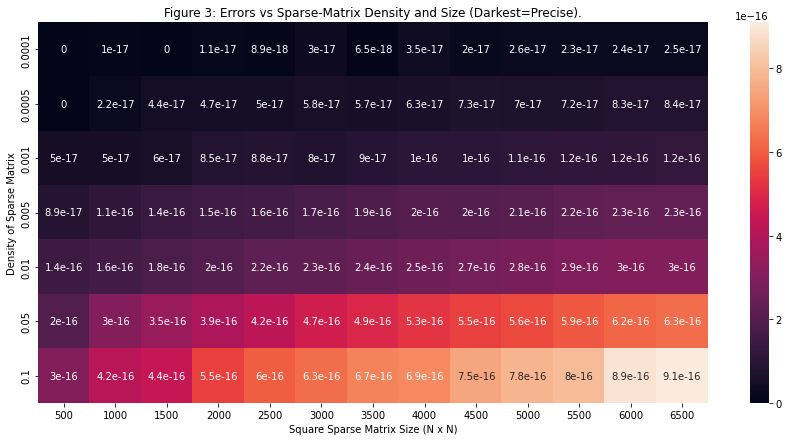

In [ ]:
data = pd.DataFrame(result_e.T, density, Ns)
plt.figure(figsize=(15, 7))
sb.heatmap(data, annot=True)
plt.title("Figure 3: Errors vs Sparse-Matrix Density and Size (Darkest=Precise).")
plt.xlabel("Square Sparse Matrix Size (N x N)")
plt.ylabel("Density of Sparse Matrix")

As expected, the least accurate matrix was the largest and most dense. There was also not much change for highly sparse matrices as the size increased. Because of this, it can be deduced that GPU kernels are most accurate for highly sparse matrices. Please note that although all of these errors are of machine order, there is an obvious trend of increasing error down and right on the graph.

##Poisson Problem

One application of Sparse matrix multiplication is when solving a discretised system. In this case, a sparse matrix is created (A) through discretising a Poisson distribution. This is then multiplied by a vector x of same row number as the matrix. 

In [ ]:
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve
from scipy.sparse.linalg import LinearOperator
from scipy.sparse import random
from scipy import sparse
Ns = [10,20,30,40,50,60,70,80,90,100]
kernal_times = []
sci_times = []
for n in Ns:
  A, f = discretise_poisson(n)
  Sparse_A = EllpackMatrix(A)
  x = np.random.randn(A.shape[1])
  time = %timeit -oq Sparse_A._matvec(vec=x)
  sci_time = %timeit -oq A @ x
  kernal_times.append(time.best)
  sci_times.append(sci_time.best)

To further investigate the abilities of the GPU method, we plot the times required to calculate a NxN SpMV with N taking 10 to 100. It is expected that the GPU will be slower (same as previous experiments) than the Scipy method. It is also expected that the relationship will be quadratic with  matrix size, as NxN means $N^2$ calculations.

Text(0, 0.5, 'Time (s)')

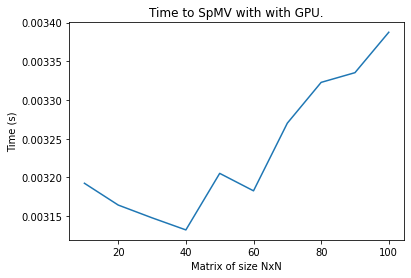

In [ ]:
plt.plot(Ns, kernal_times)
plt.title("Time to SpMV with with GPU.")
plt.xlabel("Matrix of size NxN")
plt.ylabel("Time (s)")
plt.grid()

Text(0, 0.5, 'Time (s)')

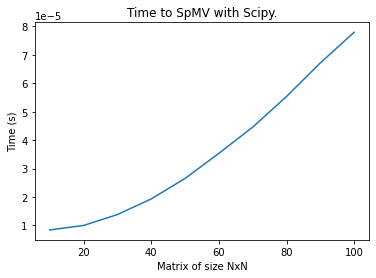

In [ ]:
plt.plot(Ns, sci_times)
plt.title("Time to SpMV with Scipy.")
plt.xlabel("Matrix of size NxN")
plt.ylabel("Time (s)")
plt.grid()

As expected, the graphs show a quadratic relationship. The two times had to be seperated onto two graphs because of the differences in magnitude. The Scipy is of the order $10^{-5}$ and the GPU is of order $10^{-3}$; they would not have been compatible together. However it can be seen that both follow a similar relationship with size, although the GPU method seems to fit the curve less easily.

##Matrix Market

### Geopolitical Matrix

In the matrixMarket the writer found an interesting matrix representation of immigration between countries. Movement from country j to country i in the time 1965-70 is represented as an element = data[i,j]. Source [9].


Matrix 1: This is a complete matrix of all data.


Matrix 2: This is a non-diagonal matrix (removed diagonal) where country x to country x movement is ignored.


Matrix 3: This is a doubly-standardized version of Matrix 2. This measn Mean and Standard Deviations are 0. This makes statistical calculations easier.

Using Matrix 1 as a basis, a comparison will be conducted and a SpMV will be executed (with identical vectors) on each of these and the times recorded. As there are some minor differences between these, the results should be interesting.

In [ ]:
from scipy import io
matrix1 = scipy.io.mmread("psmigr_1.mtx.gz")
matrix2 = scipy.io.mmread("psmigr_2.mtx.gz")
matrix3 = scipy.io.mmread("psmigr_3.mtx.gz")

In [ ]:
x = np.random.randn(matrix1.shape[0])

matrix1 = sparse.csr_matrix(matrix1)
Ellpack1 = EllpackMatrix(matrix1)
time1 = %timeit -oq Ellpack1._matvec(x)
time1 = time1.best

matrix2 = sparse.csr_matrix(matrix2)
Ellpack2 = EllpackMatrix(matrix2)
time2 = %timeit -oq Ellpack2._matvec(x)
time2 = time2.best

matrix3 = sparse.csr_matrix(matrix3)
Ellpack3 = EllpackMatrix(matrix3)
time3 = %timeit -oq Ellpack3._matvec(x)
time3 = time3.best

time1, time2, time3

(0.013770657960003518, 0.028952504999961094, 0.02839923780002209)

The first calculation is the fastest. This is interesting as the larger number of elements implies that it should be slowest. It took ~50% of the time matrix 2 required. The fact that matrix 2 and 3 require similar times is to be expected. The difference between 1 and 2 likely arrises from the non-diagonalisation. In this process, the size of just-off-diagonal elements increaases. In matrix 1 they are of order $10^{-6}$ however in matrix 2 they are of order 0.1. This can be seen in each of their 'city plots' on the matrix market site [9]. This would slow down the program as each and every line has several elements which are order of magnitudes higher than the surroundings. Working with this style of data, one could neglect the other elements and just run calculations with the just-off-diagonals, as they will dominate the calculation.  

### Economic Matrix

The next matrix is from the Australian economic models of 1968-69 [10]. It is an unstructured matrix of real elements ranging between [-4.09, 4.09]. With an average of just 36 non-zero elements per row, this is very sparse and could show GPU dominance over scipy.

In [ ]:
matrix4 = scipy.io.mmread("orani678.mtx.gz")

x = np.random.randn(matrix4.shape[0])
matrix4 = sparse.csr_matrix(matrix4)
Ellpack4 = EllpackMatrix(matrix4)
time4 = %timeit -oq Ellpack4._matvec(x)

time5 = %timeit -oq matrix4 @ x

time4.best, time5.best

(0.013747835809999743, 0.00011301621609991344)

As the reader can see, the GPU method took 121 times the time to calculate. This implies that although the GPU runs best on sparse matrices, scipy still has dominance in all tested situations. 

# Conclusions

In summary, this discussion developed a conversion of a CSR to Ellpack-R metrix converter, and a GPU implementation for multiplying sparse matrices in this Ellpakc format by vectors. 


This was benchmarked against naive and parallel methods, as well as the optimized numpy '.dot()' and Scipy '@' methods. It was found that while improvements occured for the GPU in smaller, less dense matrices, all other methods had faster calculation times. 


The error dependance of this GPU method on matrix size and density were also looked at. It was found that smaller, less dense matrices were the most accurate. 

Lastly, The GPU methods were tested on useful applications such as a discretized Poisson distribution and real world matrices. This showed that while the GPU is accurate, the speed of calculation is orders-of-magnitude too large for real world usage. The matrix market website was used to source two matrices about immigration and economic data. These ran smoothly and the calculation times were discussed.

#Citations



[1]F. Vazquez, G. Ortega, J.J. Fernandez, E.M. Garzon Improving the performance of the sparse matrix vector product with GPUs

[2] Bell N, Garland M. Implementing Sparse Matrix-Vector Multiplication on Throughput-Oriented Processors Proceedings of SC’09. http://www. nvidia.com/object/nvidia research pub 013.html

[3] Monakov,A; Lokhmotov, A; and Avetisyan, A. Automatically Tuning Sparse Matrix-Vector Multiplication for GPU Architectures Proceedings of HiPEAC 2010, LNCS 5952, pp. 111- 125, 2010

[4] https://www.jpier.org/PIER/pier116/03.11031607.pdf

[5] https://ieeexplore.ieee.org/document/6270844

[6] https://onlinelibrary.wiley.com/doi/full/10.1002/cpe.6236

[7] https://github.com/fivitti/SMDV/blob/9183b3e65f0d10b681b753bddbf3a45ad0e4395c/matrixformat.py#L459

[8] https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7013050


[9] https://math.nist.gov/MatrixMarket/data/Harwell-Boeing/psmigr/psmigr.html

[10] https://math.nist.gov/MatrixMarket/data/Harwell-Boeing/econaus/orani678.html

[11] https://people.maths.ox.ac.uk/gilesm/files/InPar_spMV.pdf